In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import re
from collections import Counter
import os
import sys
import joblib
sys.path.insert(0, os.path.abspath(os.path.join(".", "transformers")))
from preprocessing import * 
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import cartopy.crs as ccrs
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from math import radians, sin, cos, sqrt, asin

In [74]:
df = pd.read_csv('dataframes/google_places_data.csv')

In [75]:
train_df, test1_df = train_test_split(df, test_size=0.3, random_state=42)

test_df, val_df= train_test_split(test1_df, test_size=0.4, random_state=42)

# Feature engineering

In this part we will focus on:
* dealing with missing data 
* normalizing numerical features
* selecting relevant columns and deleting columns with potential mistakes
* adding new features

In [76]:
def check_for_missing(df):
    for column in df.columns:
        missing_count = df[column].isnull().sum()
        print("Missing values in column: ", column, "=", missing_count)

check_for_missing(train_df)

Missing values in column:  business_id = 0
Missing values in column:  phone_number = 0
Missing values in column:  name = 0
Missing values in column:  full_address = 0
Missing values in column:  latitude = 5
Missing values in column:  longitude = 5
Missing values in column:  review_count = 0
Missing values in column:  rating = 0
Missing values in column:  timezone = 0
Missing values in column:  website = 0
Missing values in column:  place_id = 0
Missing values in column:  place_link = 0
Missing values in column:  types = 0
Missing values in column:  Friday = 0
Missing values in column:  Saturday = 0
Missing values in column:  Sunday = 0
Missing values in column:  Monday = 0
Missing values in column:  Tuesday = 0
Missing values in column:  Wednesday = 0
Missing values in column:  Thursday = 0
Missing values in column:  city = 0
Missing values in column:  verified = 0
Missing values in column:  state = 0
Missing values in column:  Friday_morning = 0
Missing values in column:  Friday_after

We have only 5 missing values in columns latitude, longitude, geo_cluster, 
but there are also "hidden" missing values like "Unknown" in website, phone number etc

In [77]:
train_df[train_df['latitude'].isna() | train_df['longitude'].isna()]

,business_id,phone_number,name,full_address,latitude,longitude,review_count,rating,timezone,website,...,Tuesday_afternoon,Tuesday_evening,Wednesday_morning,Wednesday_afternoon,Wednesday_evening,Thursday_morning,Thursday_afternoon,Thursday_evening,geo_cluster,country
5368,0x549175bad87e4499:0xe474185a7c812203,13608880460,IJB Painting Company,Unknown,NaN,NaN,32.0,4.4,America/Los_Angeles,Unknown,...,0,0,0,0,0,0,0,0,NaN,United Arab Emirates
5355,0x80dd4a6f6bc3c0d1:0xa0dbcc9e52e67a7d,13105300994,"R Painting,License #752512",Unknown,NaN,NaN,32.0,4.4,America/Los_Angeles,Unknown,...,0,0,0,0,0,0,0,0,NaN,United Arab Emirates
12398,0x886b5c66fee9323d:0x3aa2c26684beba68,18137481822,Election Roofing and Construction LLC,Unknown,NaN,NaN,1.0,4.0,America/New_York,https://election-roofing-and-construction-llc....,...,0,0,0,0,0,0,0,0,NaN,United Arab Emirates
7683,0x3e5f43a21c43cf97:0x5ab0bd09eee41976,971524175130,S&Y Travel Agency,Unknown,NaN,NaN,32.0,4.4,Asia/Dubai,Unknown,...,0,0,0,0,0,0,0,0,NaN,United Arab Emirates
8571,0xb2afb323ceda5e5:0x9616560c124aa170,971509014567,Luxury District Real Estate,Unknown,NaN,NaN,32.0,4.4,Asia/Dubai,Unknown,...,1,1,1,1,1,1,1,1,NaN,United Arab Emirates


Now we will create groups from 'types' column, for that we used ChatGPT to determine some of the most important and often present categories, then we classify using Regex 

In [78]:
#checking for keywords in 'types' column
keywords=[]
for line in train_df['types'].unique():  
    if pd.notna(line):
        words = re.findall(r'\b\w+\b', line.lower())
        keywords.extend(words)

word_counts = Counter(keywords)
print(word_counts)


Counter({'store': 1771, 'service': 1181, 'shop': 622, 'restaurant': 619, 'dealer': 468, 'agency': 452, 'car': 424, 'repair': 302, 'clothing': 295, 'auto': 291, 'attorney': 289, 'clinic': 255, 'center': 253, 'tourist': 235, 'dental': 233, 'estate': 221, 'supplier': 218, 'attraction': 213, 'park': 207, 'jewelry': 205, 'real': 204, 'bar': 196, 'contractor': 181, 'used': 181, 's': 180, 'and': 179, 'furniture': 171, 'dentist': 170, 'pet': 165, 'hotel': 161, 'tour': 156, 'insurance': 149, 'museum': 144, 'company': 142, 'home': 134, 'designer': 124, 'school': 119, 'consultant': 119, 'law': 115, 'office': 109, 'medical': 109, 'salon': 108, 'church': 103, 'cafe': 98, 'bakery': 97, 'establishment': 97, 'rental': 96, 'supply': 95, 'coffee': 92, 'club': 91, 'flower': 91, 'beauty': 90, 'delivery': 89, 'painter': 88, 'maintenance': 82, 'venue': 79, 'firm': 78, 'art': 78, 'care': 77, 'hair': 75, 'health': 75, 'hospital': 74, 'accessories': 73, 'physical': 73, 'shoe': 72, 'cleaning': 72, 'interior': 6

In [79]:
# determined categories
main_categories = ["Hotel","Restaurant","Shop","Service","Agency","Dealer","Repair","Car","Travel","Fitness","Health","Dental","RealEstate",
    "Office","Tourist","Attraction","Park","Attorney","Bank","Pharmacy","Supermarket","Bakery","Barbershop","Hospital","Library","Museum","Cinema",
    "Store","Jeweler","Beauty"
]

All necessary dataframe transformations are in preprocessing.py transformers. What we did was:

* Remove rows with missing geographical coordinates
* Add new binary columns 1- phone/website is known and 0 if else
* We classified each row to categories given above detected by ChatGPT
* We removed columns we found irrelevant like :
1) business_id, phone numer, website, full address - as every company has a unique value
2) geographical related columns like cuntry, city, timezone, place_id etc as we found many misleading information in EDA and we will perform custom location clustering
* We Normalized relevant numerical columns like rating and review count

**Here is our data after all transformations:**

In [80]:
processing_pipeline = Pipeline([
    ('missing_location_remover', MissingGeographRemover()),
    ('contact_adder', ContactKnownAdder()),
    ('group', ClassifyType()),
    ('irrelevant_remove', IrrelevantColumnRemover()),
    ('feature_scale', NumericalNormalizer())])

joblib.dump(processing_pipeline, 'pipelines/preprocessing_pipeline.joblib') # file that we can load from different scripts

train_df=processing_pipeline.fit_transform(train_df)
val_df = processing_pipeline.fit_transform(val_df)
train_df.head(3)

,name,latitude,longitude,review_count,rating,Friday,Saturday,Sunday,Monday,Tuesday,...,Tuesday_evening,Wednesday_morning,Wednesday_afternoon,Wednesday_evening,Thursday_morning,Thursday_afternoon,Thursday_evening,Website_known,Phone_known,main_category
656,Lead Handyman Services,25.324796,55.417346,0.933346,0.358979,8-11 AM,8 AM-6 PM,8 AM-6 PM,8 AM-6 AM,8 AM-6 PM,...,0,0,0,0,0,0,0,1,1,Service
3254,Sunil Ambalavelil - Lawyer and Legal Consultan...,25.188190,55.271341,0.768221,0.640184,Hours not available,Hours not available,Hours not available,Hours not available,Hours not available,...,0,0,0,0,0,0,0,1,1,Attorney
8116,Action,52.186431,5.293758,0.999991,0.004244,8:30 AM-9 PM,8:30 AM-6 PM,10 AM-6 PM,8:30 AM-8 PM,8:30 AM-8 PM,...,0,0,0,0,0,0,0,1,1,Shop


# Geo Clustering 
We already have a column geo_cluster, but it does not provide us enough information and is rather not using Earth's curvature. Let's check if w can get more!

#### Definitions of Haversine and other functions

In [81]:
def plot_world(color_column, coord_df):
  fig, ax = plt.subplots(figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
  ax.coastlines()
  sc = ax.scatter(coord_df['longitude'], coord_df['latitude'], 
                  c=coord_df[color_column], cmap='viridis', s=1, transform=ccrs.PlateCarree())
  plt.colorbar(sc, label=f'{color_column}')
  ax.set_title('World Map with ' + f'{color_column}')
  plt.show()


In [82]:
ll_train_df1 = train_df[['latitude','longitude']]
ll_train_df1.head(3)

,latitude,longitude
656,25.324796,55.417346
3254,25.188190,55.271341
8116,52.186431,5.293758


Since sklearn does not allow use haversine distance as measure, we have to write our custome distance function and a clustering class with standard methods implemented.

In [83]:
# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2.0) ** 2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Custom KMeans class
class HaversineKMeans:
  def __init__(self, n_clusters, max_iter=300, tol=1e-4):
    self.n_clusters = n_clusters
    self.max_iter = max_iter
    self.tol = tol
    self.cluster_centers_ = None

  def fit(self, X):
    n_samples = X.shape[0]

    # Initialize centroids randomly
    initial_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
    self.cluster_centers_ = X[initial_indices]

    for i in range(self.max_iter):
      # Compute distances using Haversine formula
      distances = np.array([[haversine(lat1, lon1, lat2, lon2) 
                            for lat2, lon2 in self.cluster_centers_] 
                            for lat1, lon1 in X])

      # Assign clusters
      labels = np.argmin(distances, axis=1)

      # Compute WCSS during each iteration
      wcss = 0
      for i in range(n_samples):
        wcss += distances[i, labels[i]]**2

      # Update centroids
      new_centers = np.array([X[labels == j].mean(axis=0) for j in range(self.n_clusters)])

      # Check for convergence
      if np.all(np.abs(new_centers - self.cluster_centers_) < self.tol):
        break

      self.cluster_centers_ = new_centers

  def predict(self, X):
    distances = np.array([[haversine(lat1, lon1, lat2, lon2) 
                          for lat2, lon2 in self.cluster_centers_] 
                          for lat1, lon1 in X])
    return np.argmin(distances, axis=1)


  def wcss(self):
    if not hasattr(self, 'cluster_centers_'):
      raise ValueError("Model not fitted yet. Call 'fit' before calculating WCSS.")
    
    n_samples = X.shape[0]
    distances = np.array([[haversine(lat1, lon1, lat2, lon2) 
                          for lat2, lon2 in self.cluster_centers_] 
                          for lat1, lon1 in X])
    labels = np.argmin(distances, axis=1)
    
    wcss = 0
    for i in range(n_samples):
      wcss += distances[i, labels[i]]**2
    return wcss


### First geo clustering 

Now let's see which number of cluster should be optimal for us using the elbow method.

In [84]:
wcss = []

X = ll_train_df1[['latitude', 'longitude']].values

for k in range(2,14):
    kmeans = HaversineKMeans(n_clusters=k)
    kmeans.fit(X)
    wcss.append(kmeans.wcss()) 

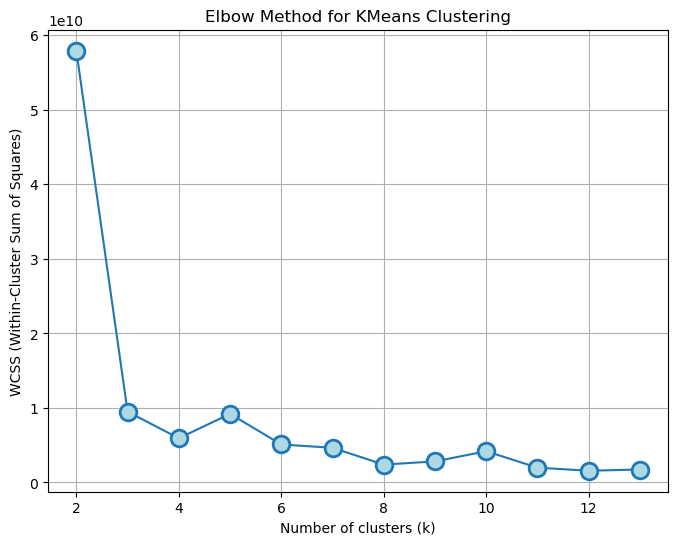

In [85]:
plt.figure(figsize=(8, 6))
krange = list(range(2,14))
plt.plot(krange, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=12)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.grid(True)
plt.show()

There is an obvious decline in WCSS after the 3rd cluster, but this is not enough for us (this number of clusterd does not even distinguish East and West USA), so we can check where is the second major decline, and its in the number of clusters is bigger. Let's create 2 possible variants for our clusters.

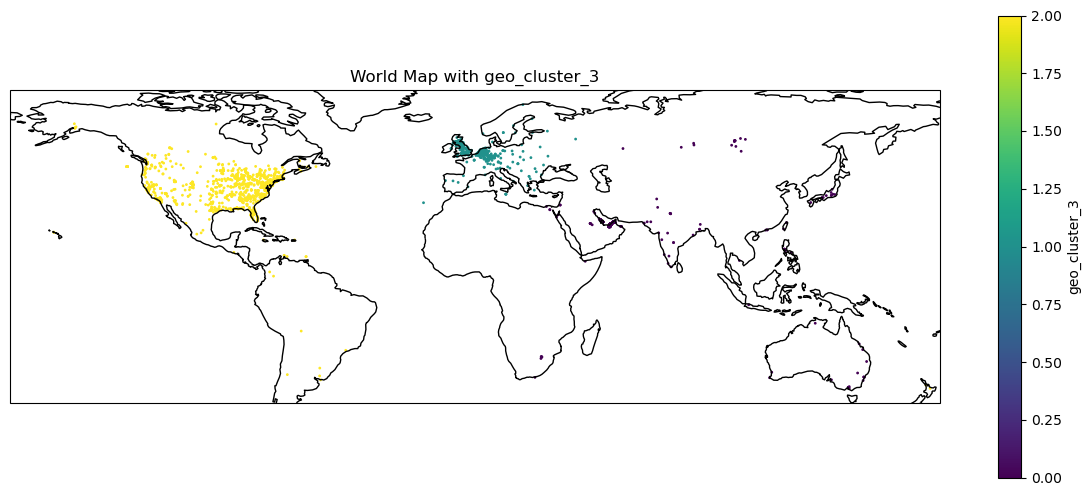

In [86]:
# Convert to numpy array
X = ll_train_df1[['latitude', 'longitude']].values

# Perform clustering
kmeans = HaversineKMeans(n_clusters=3)
kmeans.fit(X)

# Assign clusters
ll_train_df1['geo_cluster_3'] = kmeans.predict(X)
plot_world('geo_cluster_3',ll_train_df1)

We can see 3 clusters is too few for our data

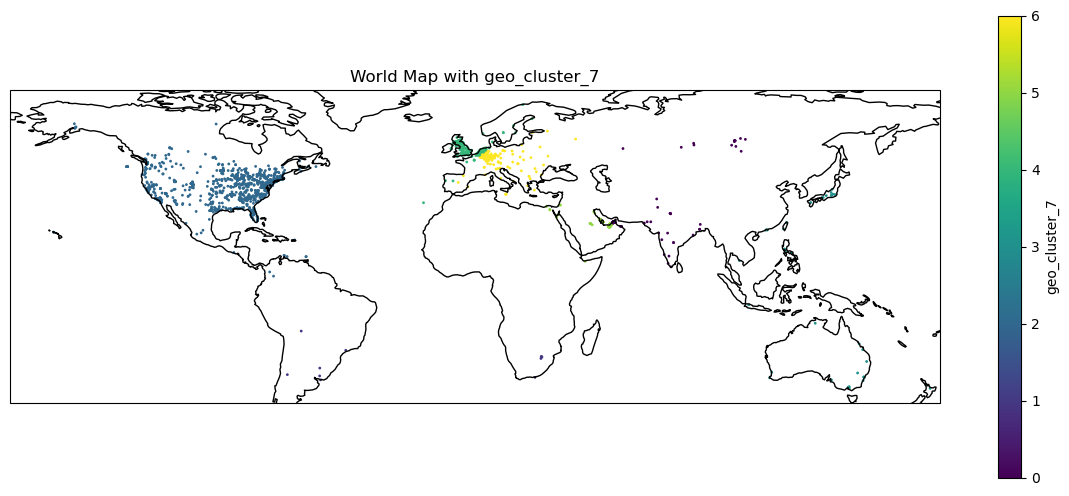

In [87]:
# Convert to numpy array
X = ll_train_df1[['latitude', 'longitude']].values

# Perform clustering
kmeans = HaversineKMeans(n_clusters=7)
kmeans.fit(X)

# Assign clusters
ll_train_df1['geo_cluster_7'] = kmeans.predict(X)
plot_world('geo_cluster_7',ll_train_df1)

We still the whole north america and europe as one cluster, we need more

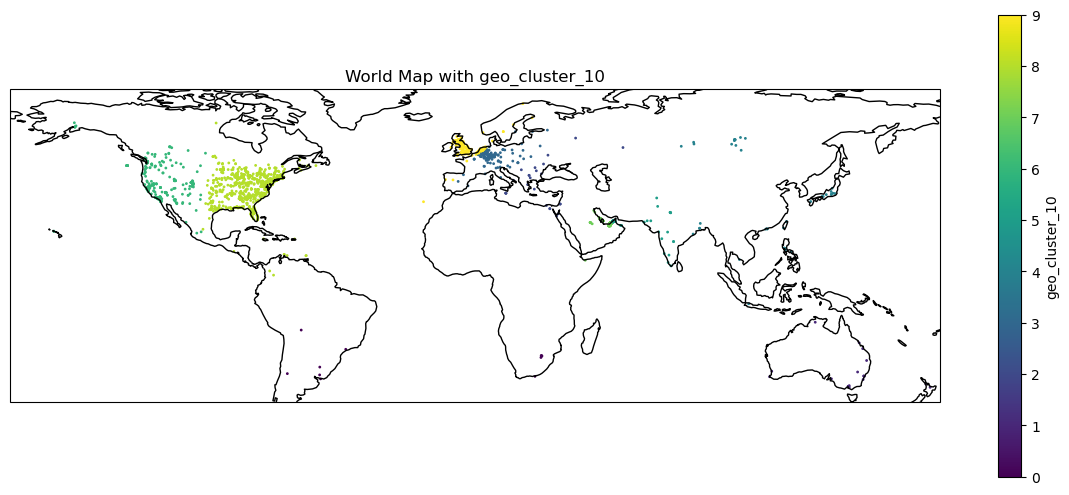

In [88]:
# Convert to numpy array
X = ll_train_df1[['latitude', 'longitude']].values

# Perform clustering
kmeans = HaversineKMeans(n_clusters=10)
kmeans.fit(X)

# Assign clusters
ll_train_df1['geo_cluster_10'] = kmeans.predict(X)
plot_world('geo_cluster_10',ll_train_df1)

#### Hierarchical clustering 

Now let's try to perform hierarchical clustering of the clusters with the biggest number of entries that are concentrated in one part of the world (North America and Europe).

In [89]:
cl2 = ll_train_df1[ll_train_df1['geo_cluster_3'] == 2]
cl1 = ll_train_df1[ll_train_df1['geo_cluster_3'] == 1]

X2 = cl2[['latitude', 'longitude']].values
X1 = cl1[['latitude', 'longitude']].values

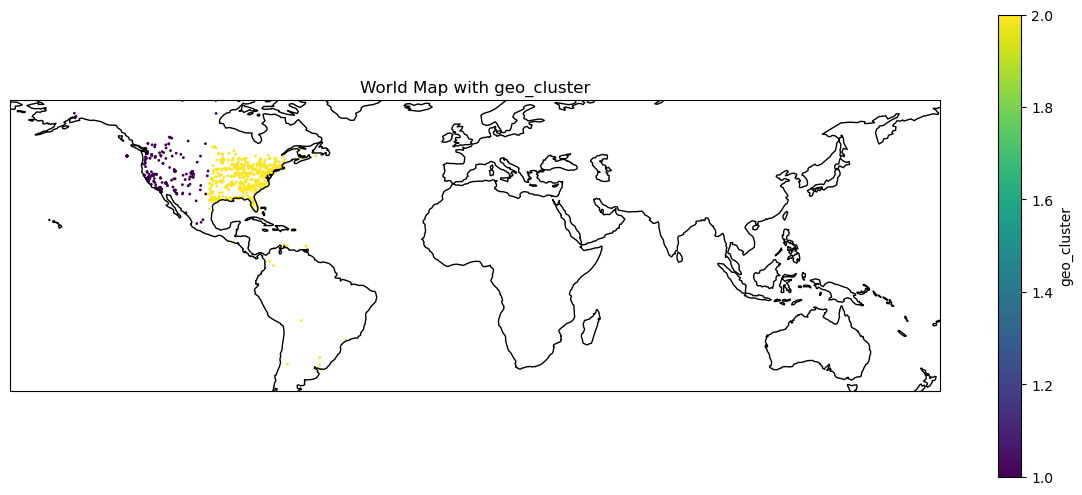

In [90]:
kmeans = HaversineKMeans(n_clusters=2)
kmeans.fit(X2)

# Assign clusters
cl2['geo_cluster'] = kmeans.predict(X2)
cl2.loc[cl2['geo_cluster'] == 0, 'geo_cluster'] = 2
plot_world('geo_cluster',cl2)

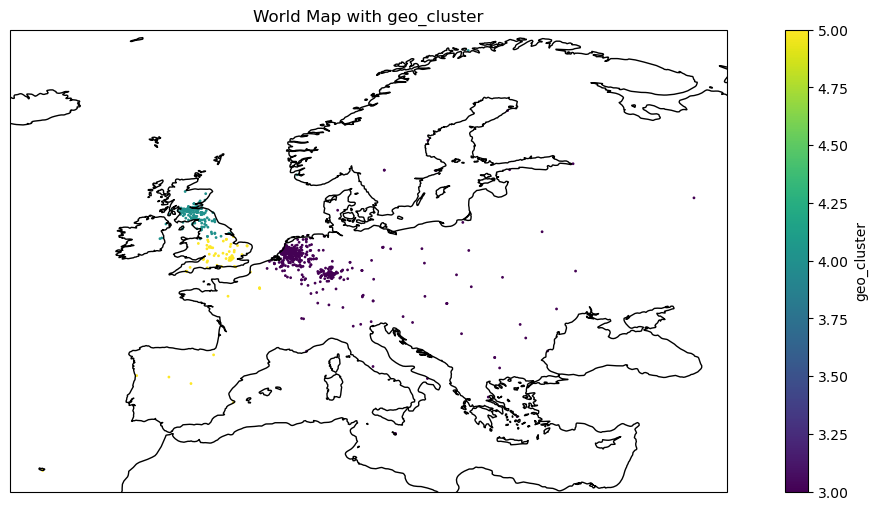

In [91]:
kmeans = HaversineKMeans(n_clusters=3)
kmeans.fit(X1)

# Assign clusters
cl1['geo_cluster'] = kmeans.predict(X1)
cl1.loc[cl1['geo_cluster'] == 0, 'geo_cluster'] = 3
cl1.loc[cl1['geo_cluster'] == 1, 'geo_cluster'] = 4
cl1.loc[cl1['geo_cluster'] == 2, 'geo_cluster'] = 5
plot_world('geo_cluster',cl1)

In [92]:
cl1 = cl1[['latitude', 'longitude','geo_cluster']]
cl2 = cl2[['latitude', 'longitude','geo_cluster']]

cl3 = ll_train_df1[ll_train_df1['geo_cluster_3']==0]
cl3 = cl3.rename(columns={'geo_cluster_3': 'geo_cluster'})
cl3 = cl3[['latitude', 'longitude','geo_cluster']]

merged_df = pd.concat([cl1, cl2, cl3], ignore_index=True)
merged_df.head()

,latitude,longitude,geo_cluster
0,52.186431,5.293758,3
1,50.104960,8.688200,3
2,52.099006,5.121644,3
3,55.935442,-4.316386,4
4,55.953772,-3.197061,4


In [93]:
preprocessed_geo_train_df = train_df.copy(deep=True)
preprocessed_geo_train_df = pd.merge(preprocessed_geo_train_df, merged_df, on=['longitude', 'latitude'])
preprocessed_geo_train_df

,name,latitude,longitude,review_count,rating,Friday,Saturday,Sunday,Monday,Tuesday,...,Wednesday_morning,Wednesday_afternoon,Wednesday_evening,Thursday_morning,Thursday_afternoon,Thursday_evening,Website_known,Phone_known,main_category,geo_cluster
0,Lead Handyman Services,25.324796,55.417346,0.933346,0.358979,8-11 AM,8 AM-6 PM,8 AM-6 PM,8 AM-6 AM,8 AM-6 PM,...,0,0,0,0,0,0,1,1,Service,0
1,Sunil Ambalavelil - Lawyer and Legal Consultan...,25.188190,55.271341,0.768221,0.640184,Hours not available,Hours not available,Hours not available,Hours not available,Hours not available,...,0,0,0,0,0,0,1,1,Attorney,0
2,Action,52.186431,5.293758,0.999991,0.004244,8:30 AM-9 PM,8:30 AM-6 PM,10 AM-6 PM,8:30 AM-8 PM,8:30 AM-8 PM,...,0,0,0,0,0,0,1,1,Shop,3
3,LIFE Pharmacy - Hala 7,25.319895,55.385263,0.999453,0.033070,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,...,1,1,1,1,1,1,1,1,Pharmacy,0
4,درب لتاجير السيارات,25.384023,55.461907,0.999460,0.032868,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,...,1,1,1,1,1,1,1,1,Service,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15034,Paradise Inn Hotel Ajman,25.387489,55.494438,0.999946,0.010367,Hours not available,Hours not available,Hours not available,Hours not available,Hours not available,...,0,0,0,0,0,0,1,1,Hotel,0
15035,Car Experts Dealership,28.603401,-81.406334,0.999811,0.019441,9 AM-7 PM,10 AM-5 PM,Closed,9 AM-7 PM,9 AM-7 PM,...,0,0,0,0,0,0,1,1,Dealer,2
15036,Closed,27.860858,-82.481460,0.990679,0.136218,Hours not available,Hours not available,Hours not available,Hours not available,Hours not available,...,0,0,0,0,0,0,1,1,Service,2
15037,ING Bank,52.152877,5.383576,0.997785,0.066519,10 AM-6 PM,10 AM-4 PM,Closed,10 AM-6 PM,10 AM-6 PM,...,0,0,0,0,0,0,1,1,Bank,3


Final result after hierarchical clustering

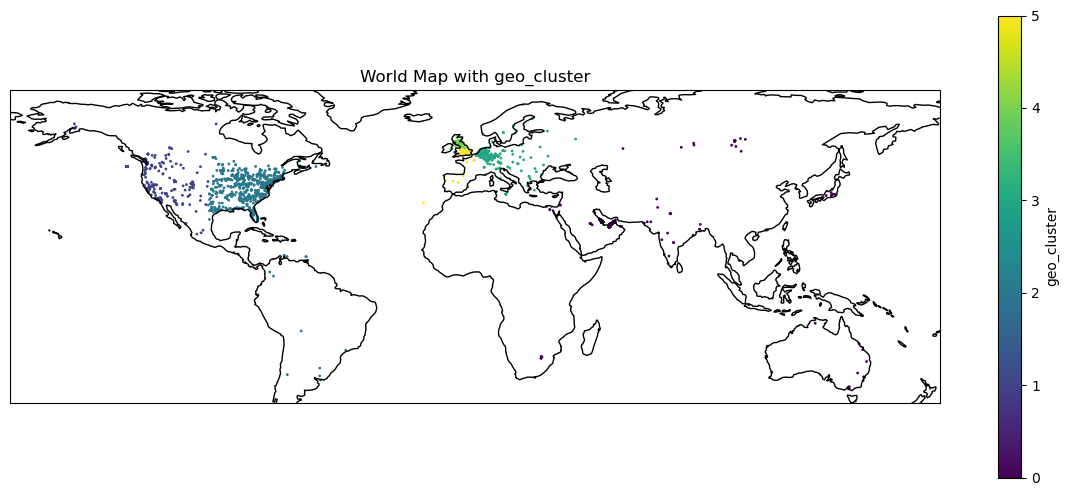

In [94]:
plot_world('geo_cluster',preprocessed_geo_train_df)

In [95]:
# save a new df as csv
preprocessed_geo_train_df.to_csv('dataframes/train_df_geo_clustered.csv', index=False)